# Semi-Supervised Training
An attempt to train something in a semi-supervised manner

https://scikit-learn.org/stable/modules/label_propagation.html

In [26]:
# Imports
import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt        # for plotting

from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.neighbors import KNeighborsClassifier
from numpy import mean

# to enable local imports
module_path = os.path.abspath('../code')
print(module_path)
if module_path not in sys.path:
    sys.path.append(module_path)

from machine_learning_data_generation import loadPickeldDataset, createXyFromFrequencyDf, loadOnlineEEGdata
from consts import TARGET_FATIGUE, TARGET_NORMAL, TARGET_UNLABELED

D:\Masterthesis\thesis_eeg\code


In [2]:
eegDataset = loadPickeldDataset("D:/Masterthesis/EEG_Data/eeg_data_online")

Load Subject 1 Data...
Load Subject 10 Data...
Load Subject 11 Data...
Load Subject 12 Data...
Load Subject 2 Data...
Load Subject 3 Data...
Load Subject 4 Data...
Load Subject 5 Data...
Load Subject 6 Data...
Load Subject 7 Data...
Load Subject 8 Data...
Load Subject 9 Data...


In [42]:
EPOCH_SERIES = 0
FREQ_DF = 1

TARGET_LABEL_DICT = {TARGET_NORMAL : 1, # positiv 
                     TARGET_UNLABELED : -1, # unlabeled
                     TARGET_FATIGUE : 0} # negative


def createSemiSupervisedDataFromOnlineEegData(eegDataset, target_label_dict, normalData = 0.3, fatigueData = 0.2) -> (np.array, np.array):
    ''' This functions creates Data for testing semi-supervised learning techniques
    
    The data creates normal and unlabeled data. For both it creates an X and y
    '''
    X_freq = None
    y_freq = None
    
    for subject in eegDataset:
        #print("Processing Subject {}...".format(subject))
        
        # calculate how much rows of each data goes to unlabeled and how much to the normal data
        normalDataPercentage = len(eegDataset[subject][TARGET_NORMAL][FREQ_DF]) - int(len(eegDataset[subject][TARGET_NORMAL][FREQ_DF]) * (1.0-normalData))

        # calculate how much rows of each data goes to unlabeled and how much to the fatige data
        fatigueDataPercentage = len(eegDataset[subject][TARGET_FATIGUE][FREQ_DF]) - int(len(eegDataset[subject][TARGET_FATIGUE][FREQ_DF]) * (1.0-fatigueData))
        
        
        normalDf = eegDataset[subject][TARGET_NORMAL][FREQ_DF][0:normalDataPercentage]
        unlabeledDf = eegDataset[subject][TARGET_NORMAL][FREQ_DF][normalDataPercentage::]

        # Create X,y from the frequency features - normal
        tempX_freq_normal, tempy_freq_normal = createXyFromFrequencyDf(freqDf = normalDf,
                                                         target = target_label_dict[TARGET_NORMAL])
        
        try:
            X_freq = np.concatenate((X_freq, tempX_freq_normal))
            y_freq = np.concatenate((y_freq, tempy_freq_normal))
        except ValueError: # happens the first, when the init value is none
            X_freq = tempX_freq_normal
            y_freq = tempy_freq_normal
        
        
        
        # Create X,y from the frequency features - normal but into the unlabeled df
        tempX_freq_unlabeled, tempy_freq_unlabeled = createXyFromFrequencyDf(freqDf = unlabeledDf,
                                                         target = target_label_dict[TARGET_UNLABELED])
            
        X_freq = np.concatenate((X_freq, tempX_freq_unlabeled))
        y_freq = np.concatenate((y_freq, tempy_freq_unlabeled))
        
        
        
                                                                                                                                             
        fatigueDf= eegDataset[subject][TARGET_NORMAL][FREQ_DF][0:fatigueDataPercentage]
        unlabeledDf = eegDataset[subject][TARGET_NORMAL][FREQ_DF][fatigueDataPercentage::]                                                                                                                                    
                                                                                                                                             
        
        # Create some fatigue labels
        tempX_freq_fatigue, tempy_freq_fatigue = createXyFromFrequencyDf(freqDf = fatigueDf,
                                                                        target = target_label_dict[TARGET_FATIGUE])
        X_freq = np.concatenate((X_freq, tempX_freq_fatigue))
        y_freq = np.concatenate((y_freq, tempy_freq_fatigue))
                                                                                                                                             
                                                                                                                                             
        # Create X,y from the frequency features - fatigue but into the unlabeled df
        tempX_freq_unlabeled_fatigue, tempy_freq_unlabeled_fatigue = createXyFromFrequencyDf(freqDf = unlabeledDf,
                                                                                             target = target_label_dict[TARGET_UNLABELED])
        
        X_freq = np.concatenate((X_freq, tempX_freq_unlabeled_fatigue))
        y_freq = np.concatenate((y_freq, tempy_freq_unlabeled_fatigue))
            
        

    print("Finished creating normal/unlabeled Freq Data")
    return (X_freq, y_freq)

In [44]:
X_freq, y_freq = createSemiSupervisedDataFromOnlineEegData(eegDataset, TARGET_LABEL_DICT)

print("X freq: {}  --- y freq {}".format(X_freq.shape, y_freq.shape))

X_freq = X_freq.reshape(1440, 1200)
# Check the contents of the set
print('{} data points and {} features'.format(X_freq.shape[0], X_freq.shape[1]))
#print('{} positive out of {} total'.format(sum(y_freq), len(y_freq)))

#hidden_size = len(y_freq) - sum(y_freq)
#print("Hidden Size: {}".format(hidden_size))

Finished creating normal/unlabeled Freq Data
X freq: (1440, 1, 1200)  --- y freq (1440,)
1440 data points and 1200 features
Hidden Size: 2304


In [45]:
eegData, freqData = loadOnlineEEGdata(splitData=False)
X_freq_orig, y_freq_orig = freqData

Loading Online EEG Data from D:/Masterthesis/EEG_Data/eeg_data_online ...
Data does not get splitted into train and test!
EEG Data Shape:
(7178, 512, 40) (7178,)
Freq Data Shape:
(1440, 1, 1200) (1440,)


## pu-learn package

In [51]:
from pulearn import ElkanotoPuClassifier
from sklearn.svm import SVC
svc = SVC(C=10, kernel='rbf', gamma=0.4, probability=True)
pu_estimator = ElkanotoPuClassifier(estimator=svc, hold_out_ratio=0.2)
pu_estimator.fit(X_freq, y_freq)

In [56]:
results['pu_learn'] = pu_estimator.predict_proba(X_freq)

In [24]:
from pulearn import BaggingPuClassifier
from sklearn.svm import SVC
svc = SVC(C=10, kernel='rbf', gamma=0.4, probability=True)
pu_estimator = BaggingPuClassifier(
    base_estimator=svc, n_estimators=15)
pu_estimator.fit(X_freq.reshape(1440,1200), y_freq)

BaggingPuClassifier(base_estimator=SVC(C=10, break_ties=False, cache_size=200,
                                       class_weight=None, coef0=0.0,
                                       decision_function_shape='ovr', degree=3,
                                       gamma=0.4, kernel='rbf', max_iter=-1,
                                       probability=True, random_state=None,
                                       shrinking=True, tol=0.001,
                                       verbose=False),
                    bootstrap=True, bootstrap_features=False, max_features=1.0,
                    max_samples=1.0, n_estimators=15, n_jobs=1, oob_score=True,
                    random_state=None, verbose=0, warm_start=False)

array([[0.90897551, 0.86066911, 0.93646745, ..., 0.        , 0.        ,
        0.        ]])

In [19]:
pu_estimator.predict(X_freq[700])

array([-1])

## Standrad classifier

In [16]:
# We'll use a generic random forest
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(
    n_estimators = 1000,  # Use 1000 trees
    n_jobs = -1           # Use all CPU cores
)
rf.fit(X_freq, y_freq)

# Store the scores assigned by this approach
results = pd.DataFrame({
    'truth'      : y_freq_orig,   # The true labels
    'label'      : y_freq,        # The labels to be shown to models in experiment
    'output_std' : rf.predict_proba(X_freq)[:,1]   # The random forest's scores
}, columns = ['truth', 'label', 'output_std'])

## Using `BaggingClassifierPU`

In [22]:
from pulearn import BaggingPuClassifier
bc = BaggingPuClassifier(
    DecisionTreeClassifier(), 
    n_estimators = 1000,  # 1000 trees as usual
    max_samples = sum(y_freq), # Balance the positives and unlabeled in each bag
    n_jobs = -1           # Use all cores
)
bc.fit(X_freq, y_freq)
results['output_skb'] = bc.oob_decision_function_[:,1]

## Comparison of approaches

In [65]:
results

,truth,label,output_std,output_skb,pu_learn
0,1,1,0.815,NaN,1.407224
1,1,1,0.790,NaN,2.220166
2,1,1,0.740,NaN,3.576929
3,1,1,0.697,NaN,4.694057
4,1,1,0.724,NaN,4.592132
...,...,...,...,...,...
1435,0,0,0.034,0.479042,0.199254
1436,0,0,0.066,0.555556,0.223077
1437,0,0,0.082,0.477791,0.200679
1438,0,0,0.092,0.424065,0.226605


In [72]:
# Prepare for graphing the performance 
# (i.e. the success in identifying hidden positives)
ts = range(100, hidden_size, 100)
y_std, y_bag, y_skb, y_stp, y_all = [], [], [], [], []

y_puLearn = []

for t in ts:
    y_std.append(
        results[results.label == 0].sort_values(
            'output_std', ascending = False
        ).head(t).truth.mean()
    )
    y_skb.append(
        results[results.label == 0].sort_values(
            'output_skb', ascending = False
        ).head(t).truth.mean()
    )
    
    y_puLearn.append(
        results[results.label == 1].sort_values(
            'pu_learn', ascending = False
        ).head(t).truth.mean()
    )

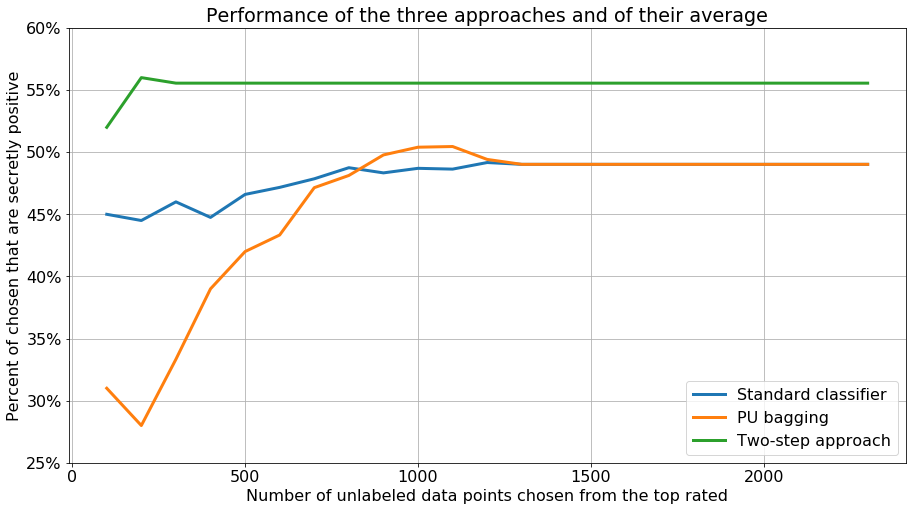

In [73]:
# Performance graphing
plt.rcParams['font.size'] = 16
plt.rcParams['figure.figsize'] = 15, 8

plt.plot(
    ts, y_std,
    ts, y_skb,
    ts, y_puLearn,
    lw = 3
)

vals = plt.gca().get_yticks()
plt.yticks(vals, ['%.0f%%' % (v*100) for v in vals])
plt.xlabel('Number of unlabeled data points chosen from the top rated')
plt.ylabel('Percent of chosen that are secretly positive')
plt.legend([
    'Standard classifier', 
    'PU bagging', 
    'Two-step approach', 
    'Average score'
])
ylim = plt.gca().get_ylim()
plt.title('Performance of the three approaches and of their average')
plt.grid()
plt.show()